<a href="https://colab.research.google.com/github/profsuccodifrutta/ai_act_RAG_navigator/blob/main/ai_act_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**CREATION OF ENVIORMENT**

In [1]:
# install uv
!curl -LsSf https://astral.sh/uv/install.sh | sh
import sys
import os
from google.colab import userdata
sys.path.append("/root/.cargo/bin")

# configuratrion github with secrets
GIT_USER = "profsuccodifrutta"
GIT_REPO = "ai_act_RAG_navigator"

try:
    # Assicurati che nell'icona della chiave il nome sia github_token
    GIT_TOKEN = userdata.get('github_token')
except Exception:
    print("ERRORE: Segreto 'github_token' non trovato. Controlla l'icona della chiave a sinistra.")
    sys.exit(1)

# clone repo
if not os.path.exists(GIT_REPO):
    !git clone https://{GIT_TOKEN}@github.com/{GIT_USER}/{GIT_REPO}.git
else:
    print(f"folder {GIT_REPO} already exists.")

# project repo
%cd {GIT_REPO}

# Fix per il remote (necessario per il push)
!git remote set-url origin https://{GIT_TOKEN}@github.com/{GIT_USER}/{GIT_REPO}.git

# initialization uv enviorment
if not os.path.exists("pyproject.toml"):
    !uv init
else:
    print("uv already initialized.")

# add libraries
!uv add langchain langchain-community langchain-google-genai faiss-cpu pymupdf spacy python-dotenv
!uv add langchain-text-splitters langchain-core
!uv pip install --system langchain-text-splitters langchain-core
# install on colab
!uv pip install --system langchain langchain-community langchain-google-genai faiss-cpu pymupdf spacy python-dotenv

print("\nEnviorment configuration completed")

downloading uv 0.10.3 x86_64-unknown-linux-gnu
no checksums to verify
installing to /usr/local/bin
  uv
  uvx
everything's installed!
Cloning into 'ai_act_RAG_navigator'...
remote: Enumerating objects: 41, done.
remote: Counting objects: 100% (41/41), done.
remote: Compressing objects: 100% (36/36), done.
remote: Total 41 (delta 16), reused 12 (delta 4), pack-reused 0 (from 0)
Receiving objects: 100% (41/41), 2.25 MiB | 14.78 MiB/s, done.
Resolving deltas: 100% (16/16), done.
/content/ai_act_RAG_navigator
uv already initialized.
Using CPython 3.12.12 interpreter at: /usr/bin/python3
Creating virtual environment at: .venv
Resolved 99 packages in 0.51ms
Prepared 97 packages in 1.85s
Installed 97 packages in 132ms
 + aiohappyeyeballs==2.6.1
 + aiohttp==3.13.3
 + aiosignal==1.4.0
 + annotated-doc==0.0.4
 + annotated-types==0.7.0
 + anyio==4.12.1
 + attrs==25.4.0
 + blis==1.3.3
 + catalogue==2.0.10
 + certifi==2026.1.4
 + cffi==2.0.0
 + charset-normalizer==3.4.4
 + click==8.3.1
 + cloudpath

In [2]:
# configuration
!git config --global user.email "matteo@drezzo.ch"
!git config --global user.name "profsuccodifrutta"
!git branch -M main

**PRE-PROCESSING**

In [3]:
from google.colab import drive
import os
import requests
import shutil
import fitz
import re
import os
import pandas as pd
import matplotlib.pyplot as plt
import gc
import random
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.documents import Document
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from spacy import displacy
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

Creates a local data/ directory within the repository, and loads the official 144-page EU AI Act PDF. It also prepares a dedicated folder on Drive to store the future FAISS vector index

In [4]:
drive.mount('/content/drive')

# local env set up
data_dir = "data"
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
    print(f"Folder '{data_dir}' created.")

# path configuration
drive_pdf_path = "/content/drive/MyDrive/compliance_and_regulation_rag/regulation_pdfs/ai_act_2024.pdf"

local_pdf_path = os.path.join(data_dir, "eu_ai_act.pdf") # local destination

# Copy file from Drive to Local Data folder
if os.path.exists(drive_pdf_path):
    shutil.copy(drive_pdf_path, local_pdf_path)
    print(f"File copied from Drive to: {local_pdf_path} ({os.path.getsize(local_pdf_path)} bytes)")
else:
    print(f"Error: File NOT found on Drive at {drive_pdf_path}")

# persistence folder for FAISS index
drive_persistence_path = "/content/drive/MyDrive/compliance_and_regulation_rag/ai_act_rag_index"
if not os.path.exists(drive_persistence_path):
    os.makedirs(drive_persistence_path)
    print("Folder for index persistence ready on Drive.")

Mounted at /content/drive
File copied from Drive to: data/eu_ai_act.pdf (2583319 bytes)


The parse_ai_act_robust() function acts as a highly specialized document parser designed to extract the EU AI Act into clean, semantically isolated legal units. First, it reads the PDF page by page, stripping away formatting noise like document links, page numbers, and line-break hyphens. Crucially, it employs a multiline regex strategy to detect and truncate footnote blocks at the bottom of the pages; this prevents those footnotes from being falsely extracted as standalone Recitals or corrupting the flow of the main text. After sanitizing the pages, it groups them into "RECITAL", "ARTICLE", and "ANNEX" buckets based on their structural locations in the document. Finally, it stitches the text back together and uses strict, newline-aware regular expressions to split the document only at true section headers, entirely ignoring inline cross-references (like "in accordance with Article 99"). This guarantees that every row in the resulting dataframe represents a single, complete, and unbroken legal concept perfectly for a RAG system.

In [5]:
def parse_ai_act_robust(pdf_path):
    doc = fitz.open(pdf_path)

    categories_text = {
        "RECITAL": [],
        "ARTICLE": [],
        "ANNEX": []
    }

    noise_pattern = re.compile(r"(\d+/144|ELI: http://data\.europa\.eu/eli/reg/.+|OJ L, 12\.7\.2024|EN|\(Text with EEA relevance\))")
    footnote_cleaner = re.compile(r"\n\s*\(\s*\d+\s*\)\s*(?:OJ\b|Position\b|Directive\b|Regulation\b|See\b|Case\b).*$", re.IGNORECASE | re.DOTALL)

    print("Reading PDF and filtering noise & footnotes...")
    footnotes_removed = 0

    for page_num in range(len(doc)):
        text = doc[page_num].get_text("text").replace("-\n", "")

        clean_lines = []
        for line in text.split("\n"):
            cleaned_line = noise_pattern.sub("", line).strip()
            if cleaned_line and not cleaned_line.isdigit():
                clean_lines.append(cleaned_line)

        # Join the page back together
        final_page_text = "\n" + "\n".join(clean_lines)

        if footnote_cleaner.search(final_page_text):
            # Replace the footnote block with a single newline
            final_page_text = footnote_cleaner.sub("\n", final_page_text)
            footnotes_removed += 1

        p_idx = page_num + 1
        if p_idx < 44:
            categories_text["RECITAL"].append(final_page_text)
        elif 44 <= p_idx <= 123:
            categories_text["ARTICLE"].append(final_page_text)
        else:
            categories_text["ANNEX"].append(final_page_text)

    doc.close()
    print(f"Success: Removed footnote blocks from {footnotes_removed} pages.")

    units = []

    # proces recitals
    recital_text = "\n" + "\n".join(categories_text["RECITAL"]) + "\n"
    rec_parts = re.split(r"\n\s*\(\s*(\d+)\s*\)\s+", recital_text)
    for i in range(1, len(rec_parts), 2):
        text_content = rec_parts[i+1].replace("\n", " ").strip()
        if text_content:
            units.append({"id": f"RECITAL {rec_parts[i]}", "category": "RECITAL", "text": text_content})

    # proces articles
    article_text = "\n" + "\n".join(categories_text["ARTICLE"]) + "\n"
    art_parts = re.split(r"(?i)\n\s*Article\s+(\d+)\s*\n", article_text)
    for i in range(1, len(art_parts), 2):
        text_content = art_parts[i+1].replace("\n", " ").strip()
        if text_content:
            units.append({"id": f"ARTICLE {art_parts[i]}", "category": "ARTICLE", "text": text_content})

    # proces annexes
    annex_text = "\n" + "\n".join(categories_text["ANNEX"]) + "\n"
    annex_parts = re.split(r"(?i)\n\s*ANNEX\s+([IVXLCDM]+)\s*\n", annex_text)
    for i in range(1, len(annex_parts), 2):
        text_content = annex_parts[i+1].replace("\n", " ").strip()
        if text_content:
            units.append({"id": f"ANNEX {annex_parts[i].upper()}", "category": "ANNEX", "text": text_content})

    return pd.DataFrame(units)

In [6]:
df_units = parse_ai_act_robust(local_pdf_path)
df_units['len'] = df_units['text'].str.len()

print(f"Clean Units created: {len(df_units)}")
print(f"Max length: {df_units['len'].max()}")

Reading PDF and filtering noise & footnotes...
Success: Removed footnote blocks from 23 pages.
Clean Units created: 307
Max length: 17095


**CHUNK ANALYSIS**

An embedding vector represents the "average" meaning of a text. If a chunk is too long and covers five different legal requirements, the vector becomes vague, making it harder for the system to find that specific information during a search. Even if an LLM can read a huge chunk, providing too much irrelevant text alongside the answer creates "noise." This increases the risk of the model hallucinating or missing the specific detail you're looking for.

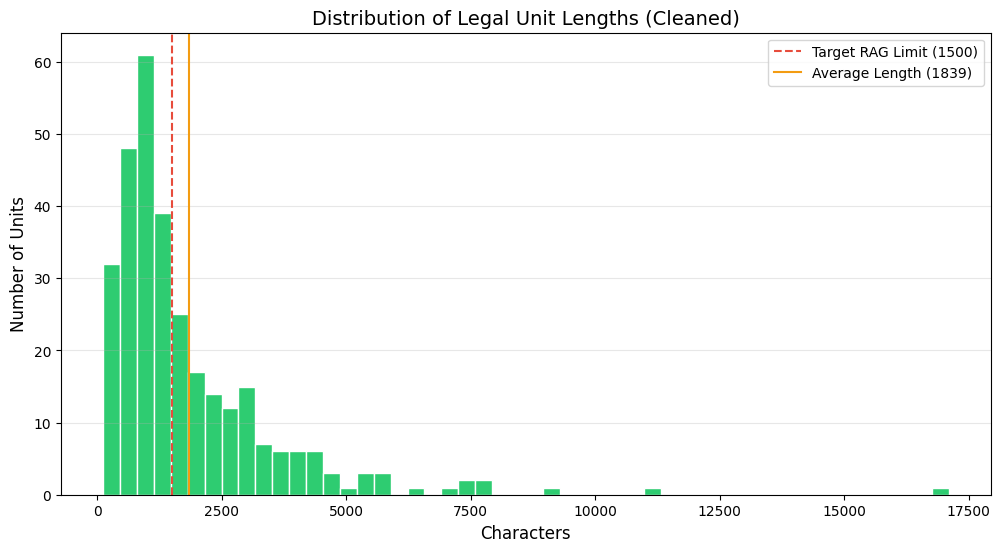

In [7]:
plt.figure(figsize=(12, 6))
plt.hist(df_units['len'], bins=50, color='#2ecc71', edgecolor='white')
plt.axvline(1500, color='#e74c3c', linestyle='--', label='Target RAG Limit (1500)')

avg_len = df_units['len'].mean()
plt.axvline(avg_len, color='#f39c12', linestyle='-', label=f'Average Length ({avg_len:.0f})')

plt.title('Distribution of Legal Unit Lengths (Cleaned)', fontsize=14)
plt.xlabel('Characters', fontsize=12)
plt.ylabel('Number of Units', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

RecursiveCharacterTextSplitter() slices the text into chunks of up to 1500 characters, maintaining a 200-character overlap to ensure no nuanced legal context is lost at the boundaries. It applies "contextual chunking" by prepending the exact legal identifier (such as [ARTICLE 10]) directly into the text of every single slice, this guarantees that the LLM always knows exactly which part of the law it is referencing. Then it packages each segment into a LangChain Document object and enriches it with highly structured metadata, including the category, legal unit, and a flag indicating if it is a continuation resulting in a robust, searchable dataset ready for embedding into the FAISS vector database.

In [8]:
# 1500 chars with 200 overlap
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1500,
    chunk_overlap=200,
    length_function=len,
    separators=["\n\n", "\n", ".", " ", ""]
)

final_documents = []

for _, row in df_units.iterrows():
    unit_id = row['id']
    category = row['category']
    text = row['text']

    chunks = text_splitter.split_text(text)

    for i, chunk in enumerate(chunks):
        enriched_content = f"[{unit_id}] {chunk}"
        doc = Document(
            page_content=enriched_content,
            metadata={
                "source": "EU_AI_Act_2024",
                "category": category,
                "legal_unit": unit_id,
                "chunk_index": i,
                "is_continuation": i > 0
            }
        )
        final_documents.append(doc)

print(f"Total vectorized chunks ready for FAISS: {len(final_documents)}")

Total vectorized chunks ready for FAISS: 577


An additional refinement step was implemented to optimize the dataset for the Retrieval-Augmented Generation architecture. Following the initial text splitting, a filtering mechanism was applied to remove 7 low-value, boilerplate chunks, specifically legislative preambles and fragmented text containing fewer than 100 characters. Addiotionaly, leading punctuation artifacts generated by the recursive splitting process were stripped. This reduction from 577 to 570 highly concentrated text chunks ensures the FAISS vector database is populated exclusively with semantically dense legal provisions. By eliminating contextual noise, this approach maximizes embedding precision, reduces retrieval latency, and mitigates the risk of LLM hallucinations during the generation phase.

In [9]:
polished_documents = []

for doc in final_documents:
    clean_text = re.sub(r"^(\[.*?\])\s*[,.]+\s*", r"\1 ", doc.page_content)

    if len(clean_text) > 100:
        doc.page_content = clean_text # update document with cleaned text
        polished_documents.append(doc)

print(f"Original chunks: {len(final_documents)}")
print(f"Polished chunks ready for vectorization: {len(polished_documents)}")
print(f"Removed {len(final_documents) - len(polished_documents)} low-value/boilerplate chunks.")

Original chunks: 577
Polished chunks ready for vectorization: 570
Removed 7 low-value/boilerplate chunks.


In [10]:
num_chunks_to_check = 4

random_chunks = random.sample(polished_documents, num_chunks_to_check)

print("=== 4 RANDOM HIGH-QUALITY CHUNKS ===\n")

for i, doc in enumerate(random_chunks):
    print(f"RANDOM CHUNK {i+1}")
    print(f"Metadata: {doc.metadata}")
    print(f"Length: {len(doc.page_content)} characters")
    print(f"Text Preview: {doc.page_content[:800]}...\n")  # Previewing 800 characters
    print("-" * 50 + "\n")

=== 4 RANDOM HIGH-QUALITY CHUNKS ===

RANDOM CHUNK 1
Metadata: {'source': 'EU_AI_Act_2024', 'category': 'ARTICLE', 'legal_unit': 'ARTICLE 96', 'chunk_index': 0, 'is_continuation': False}
Length: 1439 characters
Text Preview: [ARTICLE 96] Guidelines from the Commission on the implementation of this Regulation 1. The Commission shall develop guidelines on the practical implementation of this Regulation, and in particular on: (a) the application of the requirements and obligations referred to in Articles 8 to 15 and in Article 25; (b) the prohibited practices referred to in Article 5; (c) the practical implementation of the provisions related to substantial modification; (d) the practical implementation of transparency obligations laid down in Article 50; (e) detailed information on the relationship of this Regulation with the Union harmonisation legislation listed in Annex I, as well as with other relevant Union law, including as regards consistency in their enforcement; (f) the applicat

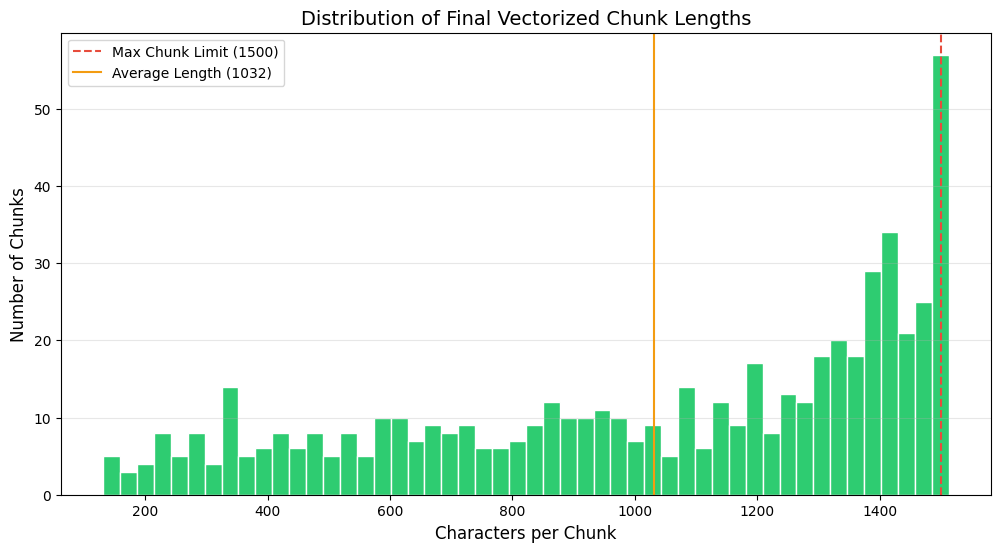

In [11]:
import matplotlib.pyplot as plt

chunk_lengths = [len(doc.page_content) for doc in polished_documents]

plt.figure(figsize=(12, 6))
plt.hist(chunk_lengths, bins=50, color='#2ecc71', edgecolor='white')

plt.axvline(1500, color='#e74c3c', linestyle='--', label='Max Chunk Limit (1500)')

if chunk_lengths:
    avg_len = sum(chunk_lengths) / len(chunk_lengths)
    plt.axvline(avg_len, color='#f39c12', linestyle='-', label=f'Average Length ({avg_len:.0f})')

plt.title('Distribution of Final Vectorized Chunk Lengths', fontsize=14)
plt.xlabel('Characters per Chunk', fontsize=12)
plt.ylabel('Number of Chunks', fontsize=12)
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.show()

Below is shown a barplot of the absolute count of chunks belonging to RECITAL, ARTICLE, and ANNEX. This proves that the dataset is heavily weighted toward operative legal text (Articles) but retains the contextual intent (Recitals).

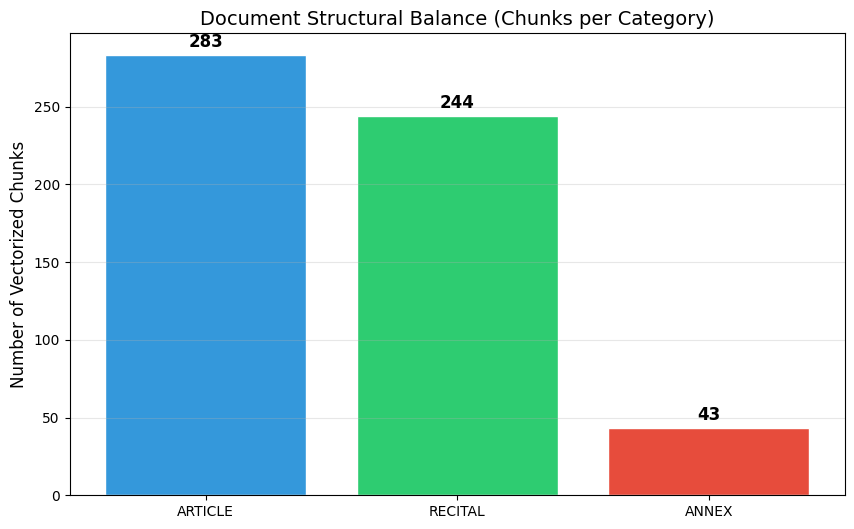

In [12]:
categories = [doc.metadata['category'] for doc in polished_documents]
category_counts = Counter(categories)

sorted_categories = sorted(category_counts.items(), key=lambda x: x[1], reverse=True)
labels = [x[0] for x in sorted_categories]
values = [x[1] for x in sorted_categories]

plt.figure(figsize=(10, 6))
bars = plt.bar(labels, values, color=['#3498db', '#2ecc71', '#e74c3c'], edgecolor='white')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + (max(values)*0.01), int(yval),
             ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.title('Document Structural Balance (Chunks per Category)', fontsize=14)
plt.ylabel('Number of Vectorized Chunks', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()

**TF-IDF exploratory analysis**


The TF-IDF approach is an essential exploratory tool for text mining because it goes far beyond simple word counts, which can often be misleading. TF-IDF evaluates the importance of a word by balancing its local frequency within a specific chunk against its global rarity across the entire dataset.  It deliberately penalizes common words that appear everywhere and assigns greater weight to terms that uniquely characterize individual documents. This mathematical filtering ensures that words with higher TF-IDF scores genuinely represent the most significant and meaningful concepts of the text.

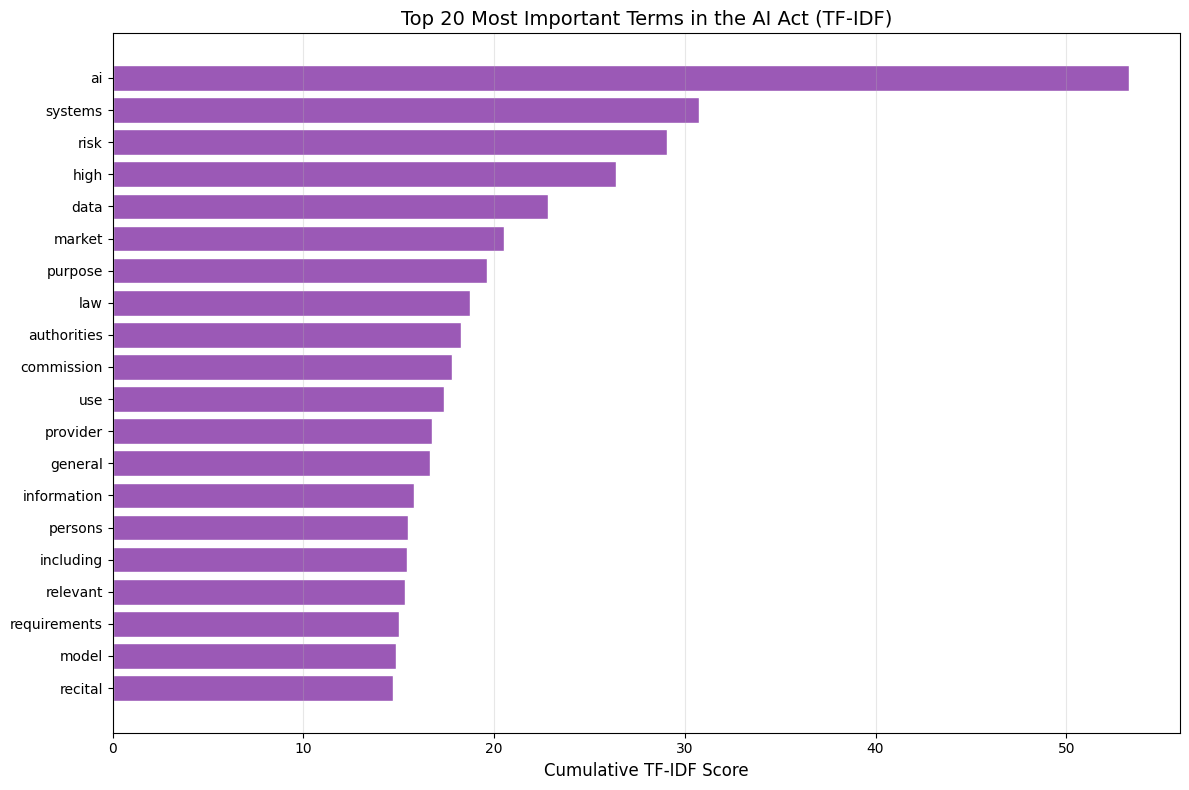

In [13]:
# Extract the raw text from all polished chunks
corpus = [doc.page_content for doc in polished_documents]

custom_stop_words = ['shall', 'article', 'regulation', 'paragraph', 'annex',
                     'member', 'states', 'union', 'eu', 'referred', 'accordance', 'chapter']
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
all_stop_words = list(ENGLISH_STOP_WORDS) + custom_stop_words

vectorizer = TfidfVectorizer(stop_words=all_stop_words, max_features=1000)
tfidf_matrix = vectorizer.fit_transform(corpus)

# Sum the TF-IDF scores for each word across the entire dataset
word_scores = tfidf_matrix.sum(axis=0).A1
words = vectorizer.get_feature_names_out()

# sort by the highest scoring words
df_words = pd.DataFrame({'word': words, 'score': word_scores})
top_20_words = df_words.sort_values(by='score', ascending=False).head(20)

top_20_words = top_20_words.sort_values(by='score', ascending=True)

plt.figure(figsize=(12, 8))
plt.barh(top_20_words['word'], top_20_words['score'], color='#9b59b6', edgecolor='white')
plt.title('Top 20 Most Important Terms in the AI Act (TF-IDF)', fontsize=14)
plt.xlabel('Cumulative TF-IDF Score', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

**NER FOR ENRICHING THE METADATA**


In a standard RAG system, the database relies entirely on dense vector embeddings to find relevant information. While vectors are excellent at understanding the semantic meaning or general theme of a question, they struggle significantly with exact keyword matching. For example, a vector search might easily confuse the legal obligations of a "Provider" with those of a "Deployer" because both concepts occupy a very similar mathematical space in the vector database.

**ERROR ANALYSIS METHODOLOGY**


Identifying and extracting these entities requires an iterative methodology known as Error Analysis, as relying entirely on pre-trained machine learning models for domain-specific legal text will lead to systemic failures. Pre-trained NLP models calculate statistical probabilities based on everyday internet text; they get easily confused by the dense capitalization, roman numerals, and acronyms found in the AI Act.

To overcome this, we established an iterative feedback loop:


1.   Baseline Definition: We injected a baseline set of deterministic rules (the EntityRuler) into the pipeline before the machine learning component.
2.   Visual Diagnostics: We ran random samples of the text through the pipeline and used a visualizer (displaCy) to inspect the model's behavior.
3. Identifying False Positives & Negatives: By reading the annotated text, we spotted areas where the model missed critical terms.
4. Rule Calibration: We updated our deterministic rules to either explicitly classify these edge cases (e.g. assigning "Annexes" to DOCUMENT)


The rules that drive this extraction are defined in a simple but highly powerful Python list called patterns. Every rule is a dictionary containing two key-value pairs: the "label" (which dictates the category, like "ORG" or "RISK_LEVEL") and the "pattern" (which defines what text to look for).

In [19]:
nlp = spacy.load("en_core_web_sm")

ruler = nlp.add_pipe("entity_ruler", before="ner")

patterns = [
# --- ORGANIZATIONS & AUTHORITIES ---
    {"label": "ORG", "pattern": "AI Office"},
    {"label": "ORG", "pattern": "European Artificial Intelligence Board"},
    {"label": "ORG", "pattern": "Market Surveillance Authority"},
    {"label": "ORG", "pattern": [{"lower": "european"}, {"lower": "commission"}]},

    # fix Entity Fragmentation for Data Protection bodies
    {"label": "ORG", "pattern": "European Data Protection Board"},
    {"label": "ORG", "pattern": "European Data Protection Supervisor"},
    {"label": "ORG", "pattern": "EDPB"},
    {"label": "ORG", "pattern": "EDPS"},

    # NEW: Legal Shorthands (Case-sensitive because they are Proper Nouns in the text)
    {"label": "ORG", "pattern": "Board"},
    {"label": "ORG", "pattern": "Commission"},

    # GEOPOLITICAL ENTITIES
    {"label": "GPE", "pattern": "Union"},
    {"label": "GPE", "pattern": "EU"},

    # STRUCTURAL LEGAL ELEMENTS
    {"label": "DOCUMENT", "pattern": "Regulation"},
    {"label": "DOCUMENT", "pattern": "Directive"},
    {"label": "DOCUMENT", "pattern": [{"lower": "annex"}, {"IS_ALPHA": True, "IS_UPPER": True}]},
    {"label": "DOCUMENT", "pattern": [{"lower": "annexes"}, {"IS_ALPHA": True, "IS_UPPER": True}]},

    # Chapters (Catches both "Chapter 3" and "Chapter III")
    {"label": "LAW", "pattern": [{"lower": "chapter"}, {"IS_DIGIT": True}]},
    {"label": "LAW", "pattern": [{"lower": "chapter"}, {"IS_ALPHA": True, "IS_UPPER": True}]},

    # Sections (Catches both "Section 2" and "Section IV")
    {"label": "LAW", "pattern": [{"lower": "section"}, {"IS_DIGIT": True}]},
    {"label": "LAW", "pattern": [{"lower": "section"}, {"IS_ALPHA": True, "IS_UPPER": True}]},
    {"label": "LAW", "pattern": [{"lower": "sections"}, {"IS_DIGIT": True}]},
    {"label": "LAW", "pattern": [{"lower": "sections"}, {"IS_ALPHA": True, "IS_UPPER": True}]},

    # Articles
    {"label": "LAW", "pattern": [{"lower": "article"}, {"IS_DIGIT": True}]},

    # Domain Stop Words
    {"label": "IGNORE", "pattern": "AI"},
    {"label": "IGNORE", "pattern": [{"lower": "artificial"}, {"lower": "intelligence"}]},
    {"label": "IGNORE", "pattern": [{"lower": "ai"}, {"lower": "system"}]},

    # CONCEPTS, LEGAL ROLES and RISK LEVELS
    {"label": "CONCEPT", "pattern": "CE"},
    {"label": "CONCEPT", "pattern": [{"text": "CE"}, {"lower": "marking"}]},
    {"label": "CONCEPT", "pattern": [{"lower": "general"}, {"IS_PUNCT": True, "OP": "?"}, {"lower": "purpose"}, {"lower": "ai"}]},
    {"label": "LEGAL_ROLE", "pattern": [{"lower": "provider"}]},
    {"label": "LEGAL_ROLE", "pattern": [{"lower": "providers"}]},
    {"label": "LEGAL_ROLE", "pattern": [{"lower": "deployer"}]},
    {"label": "LEGAL_ROLE", "pattern": [{"lower": "deployers"}]},
    {"label": "RISK_LEVEL", "pattern": [{"lower": "high"}, {"IS_PUNCT": True, "OP": "?"}, {"lower": "risk"}]},
    {"label": "RISK_LEVEL", "pattern": [{"lower": "unacceptable"}, {"lower": "risk"}]}
]

ruler.add_patterns(patterns)


sample_chunks = random.sample(polished_documents, 3)

for i, doc in enumerate(sample_chunks):
    print(f"\n--- CHUNK {i+1} (Source: {doc.metadata['legal_unit']}) ---")
    spacy_doc = nlp(doc.page_content)

    custom_colors = {
        "LEGAL_ROLE": "linear-gradient(90deg, #f1c40f, #f39c12)",
        "RISK_LEVEL": "linear-gradient(90deg, #e74c3c, #c0392b)",
        "CONCEPT": "linear-gradient(90deg, #3498db, #2980b9)",
        "DOCUMENT": "linear-gradient(90deg, #9b59b6, #8e44ad)",
        "LAW": "linear-gradient(90deg, #34495e, #2c3e50)",
        "GPE": "linear-gradient(90deg, #2ecc71, #27ae60)"
    }

    #  hides the 'IGNORE' tags
    visible_ents = ["ORG", "GPE", "DOCUMENT", "LAW", "CONCEPT", "LEGAL_ROLE", "RISK_LEVEL"]

    options = {
        "colors": custom_colors,
        "ents": visible_ents
    }

    displacy.render(spacy_doc, style="ent", jupyter=True, options=options)


--- CHUNK 1 (Source: RECITAL 121) ---



--- CHUNK 2 (Source: ARTICLE 41) ---



--- CHUNK 3 (Source: ARTICLE 90) ---


LangChain wraps every chunk of the text into a specific Python object called a Document, it has exactly two parts:


1.   page_content: A single string of text
2.   metadata: A standard Python Dictionary

to add a brand new piece of information, simply invent a new key and assign it a value (my_dict["new_invented_key"] = "new value!")


The true metadata enrichement happens here:

In [15]:
for doc in polished_documents:

    spacy_doc = nlp(doc.page_content)

    #  sets {} to collect unique entities found in this specific chunk
    extracted = {
        "organizations": set(),
        "geopolitical": set(),
        "documents": set(),
        "laws": set(),
        "concepts": set(),
        "legal_roles": set(),
        "risk_levels": set()
    }

    # categorize the extracted entities
    for ent in spacy_doc.ents:
        if ent.label_ == "ORG": extracted["organizations"].add(ent.text)
        elif ent.label_ == "GPE": extracted["geopolitical"].add(ent.text)
        elif ent.label_ == "DOCUMENT": extracted["documents"].add(ent.text)
        elif ent.label_ == "LAW": extracted["laws"].add(ent.text)
        elif ent.label_ == "CONCEPT": extracted["concepts"].add(ent.text)
        elif ent.label_ == "LEGAL_ROLE": extracted["legal_roles"].add(ent.text)
        elif ent.label_ == "RISK_LEVEL": extracted["risk_levels"].add(ent.text)

    # inject these as new keys in the document's metadata dictionary
    doc.metadata["ner_organizations"] = list(extracted["organizations"]) # to list since faiss need standard array formats
    doc.metadata["ner_geopolitical"] = list(extracted["geopolitical"])
    doc.metadata["ner_documents"] = list(extracted["documents"])
    doc.metadata["ner_laws"] = list(extracted["laws"])
    doc.metadata["ner_concepts"] = list(extracted["concepts"])
    doc.metadata["ner_legal_roles"] = list(extracted["legal_roles"])
    doc.metadata["ner_risk_levels"] = list(extracted["risk_levels"])


sample_doc = random.choice(polished_documents)

print("\n=== METADATA VERIFICATION ===")
print(f"Legal Unit: {sample_doc.metadata['legal_unit']}")
print(f"Text Preview: {sample_doc.page_content[:150]}...")
print("\nInjected NER Metadata:")
print(f"- Organizations: {sample_doc.metadata['ner_organizations']}")
print(f"- Legal Roles: {sample_doc.metadata['ner_legal_roles']}")
print(f"- Risk Levels: {sample_doc.metadata['ner_risk_levels']}")
print(f"- Concepts: {sample_doc.metadata['ner_concepts']}")
print(f"- Laws: {sample_doc.metadata['ner_laws']}")
print(f"- Documents: {sample_doc.metadata['ner_documents']}")
print(f"- Geopolitical: {sample_doc.metadata['ner_geopolitical']}")


=== METADATA VERIFICATION ===
Legal Unit: ARTICLE 70
Text Preview: [ARTICLE 70] The Commission shall transmit that information to the Board for discussion and possible recommendations. 7. The Commission shall facilita...

Injected NER Metadata:
- Organizations: ['Commission', 'the European Data Protection', 'Board']
- Legal Roles: []
- Risk Levels: ['HIGH-RISK']
- Concepts: []
- Laws: ['ARTICLE 70', 'CHAPTER VIII']
- Documents: ['Regulation']
- Geopolitical: ['EU', 'Union']


**EMBEDDDING THE CHUNKS AND CREATION OF DATABASE**

In [16]:
!pip install sentence-transformers faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.2/494.2 kB 10.1 MB/s eta 0:00:00


In [ ]:
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS

hf_embeddings = HuggingFaceEmbeddings(
    model_name="BAAI/bge-m3",
    model_kwargs={'device': 'cuda'},
    encode_kwargs={'normalize_embeddings': True}
)
print("Model loaded")

print(f"Embedding {len(polished_documents)} chunks. This will take a moment...")

vectorstore = FAISS.from_documents(polished_documents, hf_embeddings) # text to gpu, vectorizes, and organizes in FAISS index
print("FAISS index built")

vectorstore.save_local(drive_persistence_path)

print("\n Vector database created and saved")

**PUSH**

In [21]:
# for pushing
!git add .
!git commit -m "env created"
!git push -u origin main

On branch main
Your branch is up to date with 'origin/main'.

nothing to commit, working tree clean
Branch 'main' set up to track remote branch 'main' from 'origin'.
Everything up-to-date
